# Investigate a stock to understand what the target "looks like"

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
#from pprint import pprint
import numpy as np

import random
#import memory_profiler
#import altair as alt
#from tqdm import tqdm
import datetime

#import ipython_memory_usage
#%ipython_memory_usage_start


In [4]:
from utility import ROOT, TEST_CSV, TRAIN_CSV
df_train_all = pd.read_csv(TRAIN_CSV)
df_train_all = df_train_all.set_index(['stock_id', 'time_id'])

Utility says ROOT is /home/ian/data/kaggle/optiver_volatility/


In [5]:
df_train_all.shape

(428932, 1)

In [6]:
df_train_all.sample(100)

,,target
stock_id,time_id,
15,30793,0.003930
105,14093,0.001598
113,23598,0.003622
101,13124,0.004233
5,26277,0.002471
...,...,...
64,13425,0.001634
85,26973,0.002755
4,7258,0.013900


In [7]:
def show_details(df):
    try:
        nbr_index_levels = len(df.index.levels)
    except AttributeError:
        nbr_index_levels = 1
    nbr_nulls = df.isnull().sum().sum()
    #nulls_msg = "Has no nulls"
    #if nbr_nulls==0:
    nulls_msg = f"{nbr_nulls} nulls"
    is_view_msg = f'is_view {df_train_all._data.is_view}'
    is_single_block_msg = f'is_single_block {df_train_all._data.is_single_block}'
    is_consolidated_msg = f'is_consolidated {df_train_all._data.is_consolidated()}'   
    is_mixed_numeric = f'numeric mixed {df._data.is_numeric_mixed_type}'
    print(f'[{nbr_index_levels}c] {df.shape[0]:,}x{df.shape[1]:,}, {nulls_msg}, {is_view_msg}, {is_single_block_msg}, {is_consolidated_msg}, {is_mixed_numeric}')

    

def set_common_mpl_styles(
    ax, legend=True, grid_axis="y", ylabel=None, xlabel=None, title=None, ymin=None, xmin=None
):
    ax.grid(axis=grid_axis)
    if legend == False:
        ax.legend_.remove()
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    if ylabel is not None:
        ax.set_ylabel(ylabel)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if title is not None:
        ax.set_title(title)
    if ymin is not None:
        ax.set_ylim(ymin=ymin)
    if xmin is not None:
        ax.set_xlim(xmin=xmin)
    
show_details(df_train_all)

[2c] 428,932x1, 0 nulls, is_view True, is_single_block True, is_consolidated True, numeric mixed True


## Identify best/worst plots

In [8]:
df_train = pd.read_csv(os.path.join(ROOT, 'train.csv'))
df_train.sort_values('target', ascending=False)

,stock_id,time_id,target
263356,77,24600,0.070321
202001,59,23823,0.069165
65474,18,2956,0.059256
117293,33,19725,0.051955
56013,15,19725,0.049287
...,...,...,...
107743,31,4142,0.000137
110479,31,27174,0.000123
107832,31,4867,0.000113
107548,31,2479,0.000109


## Get book data

In [9]:
stock_id = 0
time_id = 5

stock_id = 80
time_id = 20498

#stock_id = 40
#time_id = 10017

stock_id = 81
time_id = 14982


# high target
#stock_id = 77
#time_id = 24600
stock_id = 59
time_id = 23823

# low target
#stock_id = 31
#time_id = 8534
#time_id = 27174

filename = 'book_train.parquet'
assert isinstance(stock_id, int)
df_book_train_stock_X = pd.read_parquet(
    os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
)
df_book_train_stock_X["stock_id"] = stock_id
df_book_train_stock_X = df_book_train_stock_X.set_index(['stock_id', 'time_id'])
df_book_train_stock_X.reset_index().time_id.unique()

array([    5,    11,    16, ..., 32758, 32763, 32767])

In [10]:
df_book_train_stock_X.head()

seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
stock_id time_id                                                          
59       5                        0    1.000847    1.001159    1.000803   
         5                        1    1.000847    1.001159    1.000803   
         5                        3    1.000892    1.001472    1.000847   
         5                        5    1.000892    1.001472    1.000847   
         5                        9    1.000892    1.001427    1.000847   

                  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
stock_id time_id                                                          
59       5          1.001427        100         14        300        121  
         5          1.001427        100        107        300        108  
         5          1.001605          8          8        100          1  
         5          1.001605          8         10        100          1  
         5          1.001472          8         29        100          2

In [11]:
df_sub = df_book_train_stock_X.query('time_id == @time_id').set_index('seconds_in_bucket')
df_sub

,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
seconds_in_bucket,,,,,,,,
0,0.999763,1.000237,0.999526,1.000553,485,200,280,146
2,0.999763,1.000237,0.999526,1.000553,485,200,280,146
3,1.000237,1.000553,0.999803,1.000592,546,146,338,44
4,0.999803,1.000553,0.999526,1.000592,338,146,180,44
5,0.999803,1.000553,0.999526,1.000592,338,146,280,44
...,...,...,...,...,...,...,...,...
590,0.998500,0.999250,0.998302,0.999605,111,200,10,44
594,0.998500,0.999250,0.998302,0.999447,110,200,10,57
595,0.998539,0.999250,0.998500,0.999447,117,200,110,57


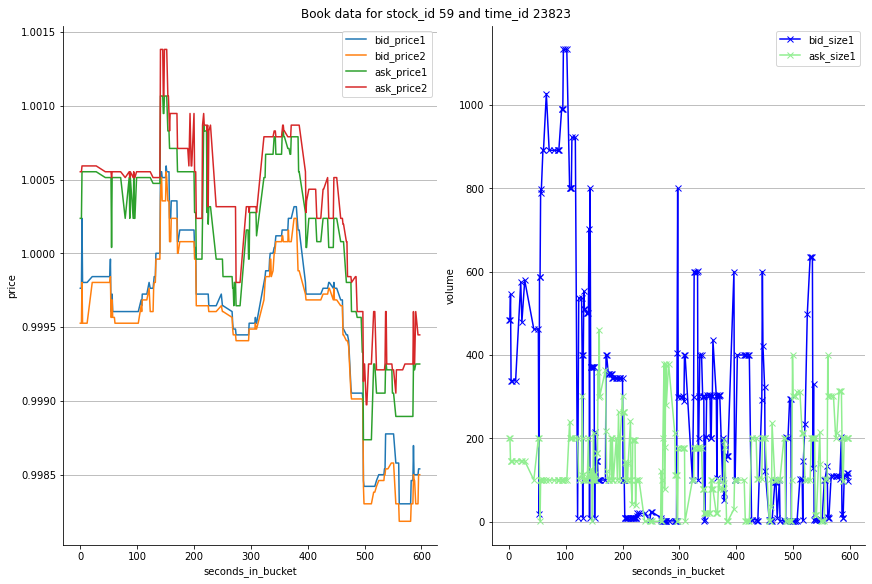

In [12]:
fig, axs = plt.subplots(ncols=2, figsize=(12,8), constrained_layout=True)
ax = axs[0]
df_sub[['bid_price1', 'bid_price2', 'ask_price1', 'ask_price2']].plot(ax=ax)
set_common_mpl_styles(ax, ylabel='price')
ax=axs[1]
# TODO figure out colors!
# only show bid/ask 1 as they're quite spikey and the plot gets confused
df_sub[['bid_size1', 'ask_size1']].plot(ax=ax, marker='x', linestyle='-', color=['blue', 'lightgreen'])
set_common_mpl_styles(ax, ylabel='volume')
fig.suptitle(f'Book data for stock_id {stock_id} and time_id {time_id}');

In [13]:
df_sub.bid_size1.value_counts().head(10)

10     25
2      22
100    14
3      13
400    11
301     8
344     8
891     7
371     7
800     6
Name: bid_size1, dtype: int64

In [14]:
df_sub.ask_size1.value_counts().head(10)

100    46
200    24
1      24
101    18
178    12
78      9
201     9
20      8
146     7
2       7
Name: ask_size1, dtype: int64

## Trade data

In [15]:
filename = 'trade_train.parquet'
assert isinstance(stock_id, int)
df_trade_train_stock_X = pd.read_parquet(
    os.path.join(ROOT, f"{filename}/stock_id={stock_id}")
)
df_trade_train_stock_X["stock_id"] = stock_id
df_trade_train_stock_X = df_trade_train_stock_X.set_index(['stock_id', 'time_id'])
df_trade_train_stock_X.head()

seconds_in_bucket     price  size  order_count
stock_id time_id                                                
59       5                        0  1.000855   453           11
         5                        3  1.001159   107            3
         5                       17  1.001494   251            9
         5                       18  1.001739     1            1
         5                       35  1.002007    78            3

In [16]:
df_trade_sub = df_trade_train_stock_X.query('time_id == @time_id').set_index('seconds_in_bucket')
df_trade_sub = df_trade_sub.reindex(index=np.arange(0, 600))
df_trade_sub['size'] = df_trade_sub['size'].fillna(0)
df_trade_sub['order_count'] = df_trade_sub['order_count'].fillna(0).astype(int)

In [17]:
df_trade_sub.head()

,price,size,order_count
seconds_in_bucket,,,
0,NaN,0.0,0
1,NaN,0.0,0
2,NaN,0.0,0
3,1.000237,200.0,3
4,1.000237,100.0,1


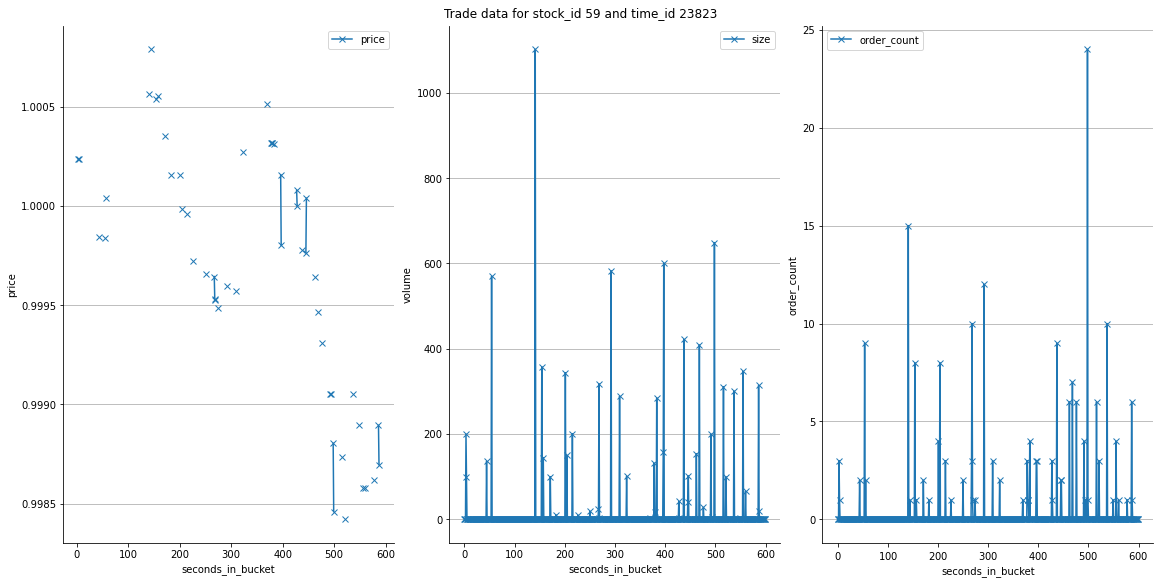

In [18]:
fig, axs = plt.subplots(ncols=3, figsize=(16,8), constrained_layout=True)
ax = axs[0]
df_trade_sub[['price']].plot(ax=ax, marker='x')
set_common_mpl_styles(ax, ylabel='price')
ax=axs[1]
# only show bid/ask 1 as they're quite spikey and the plot gets confused
df_trade_sub[['size']].plot(ax=ax, marker='x', linestyle='-')
set_common_mpl_styles(ax, ylabel='volume')
ax = axs[2]
df_trade_sub[['order_count']].plot(ax=ax, marker='x')
set_common_mpl_styles(ax, ylabel='order_count')

# DIAGNOSE https://matplotlib.org/stable/gallery/ticks_and_spines/tick-formatters.html
# I want scalar formatting
from matplotlib import ticker
ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useMathText=True))
fig.suptitle(f'Trade data for stock_id {stock_id} and time_id {time_id}');

# Calculate a metric on a `time_id` for this `stock_id`

In [19]:
df_book_train_stock_X.head()

seconds_in_bucket  bid_price1  ask_price1  bid_price2  \
stock_id time_id                                                          
59       5                        0    1.000847    1.001159    1.000803   
         5                        1    1.000847    1.001159    1.000803   
         5                        3    1.000892    1.001472    1.000847   
         5                        5    1.000892    1.001472    1.000847   
         5                        9    1.000892    1.001427    1.000847   

                  ask_price2  bid_size1  ask_size1  bid_size2  ask_size2  
stock_id time_id                                                          
59       5          1.001427        100         14        300        121  
         5          1.001427        100        107        300        108  
         5          1.001605          8          8        100          1  
         5          1.001605          8         10        100          1  
         5          1.001472          8         29        100          2

In [126]:
from numba import njit
#@njit #(cache=True)
#@njit()
def _realized_volatility_weighted_sub(ser, weights):
    ser_weighted = ser * weights
    return np.sqrt(np.sum(ser_weighted**2))

def realized_volatility_weighted(ser, weights_type):
    """Weighted volatility"""
    # as a numpy array
    # we drop from 12us to 3us by adding @njit to the _sub function
    # we can't make _sub a closure, it loses all compilation benefits
    # and we can't add njit(cache=True) in Jupyter as it can't
    # find a cache location    
    # as a Series we have 5us and 15us w/wo @njit respectively
    if isinstance(ser, pd.Series):
        ser = ser.to_numpy()
    nbr_items = ser.shape[0]
    if weights_type == 'uniform':
        weights = np.ones(nbr_items)
    elif weights_type == 'linear':
        weights = np.linspace(0.1, 1, nbr_items) # linear increasing weight
    elif weights_type == 'half0half1':
        half_way = int(ser.shape[0] / 2)
        weights = np.concatenate((np.zeros(half_way), np.ones(ser.shape[0] - half_way))) # 0s then 1s weight
    elif weights_type == 'geom':
        weights = np.geomspace(0.01, 1, nbr_items) # geometric increase
    #assert isinstance(weights_type, str) == False, f"Must not be a string like '{weights}' at this point"
    return _realized_volatility_weighted_sub(ser, weights)

series_log_return = pd.Series(np.linspace(0, 10, 6))
realized_volatility_weighted(series_log_return, weights_type="uniform")

#%timeit realized_volatility_weighted(series_log_return, weights_type="uniform")

14.832396974191326

In [127]:
def log_return(list_stock_prices):
    return np.log(list_stock_prices).diff()

def realized_volatility(series_log_return):
    return np.sqrt(np.sum(series_log_return**2))

def realized_volatility_weightedXX(series_log_return, weights=None):
    """Weighted volatility"""
    ser = series_log_return
    nbr_items = ser.shape[0]
    if weights == 'uniform':
        weights = np.ones(nbr_items)
    elif weights == 'linear':
        weights = np.linspace(0.1, 1, nbr_items) # linear increasing weight
    elif weights == 'half0half1':
        half_way = int(series_log_return.shape[0] / 2)
        weights = np.concatenate((np.zeros(half_way), np.ones(series_log_return.shape[0] - half_way))) # 0s then 1s weight
    elif weights == 'geom':
        weights = np.geomspace(0.01, 1, nbr_items) # geometric increase
    assert isinstance(weights, str) == False, f"Must not be a string like '{weights}' at this point"
    ser_weighted = ser * weights
    return np.sqrt(np.sum(ser_weighted**2))

#from numba import njit
#realized_volatility_weighted = njit(realized_volatility_weighted)

if False:
    # example usage
    series_log_return = np.linspace(0, 10, 6)
    weights = np.linspace(0.1, 1, series_log_return.shape[0]) # linear increasing weight

    half_way = int(series_log_return.shape[0] / 2)
    weights = np.concatenate((np.zeros(half_way), np.ones(series_log_return.shape[0] - half_way))) # 0s then 1s weight

    weights = np.ones(series_log_return.shape[0]) # use all items equally
    assert weights.shape[0] == series_log_return.shape[0]
    realized_volatility_weighted(series_log_return, weights)

In [128]:
if False:
    # calculate a standard statistic e.g. mean, var on a single column
    col = ['bid_price1']
    method = 'var'
    df_features = df_book_train_stock_X.groupby('time_id')[col].agg(method)

In [129]:
%%time 

def make_wap(df_book_data, num=1):
    """Modifies df_book_data"""
    assert num==1 or num==2
    wap_numerator = (df_book_data[f'bid_price{num}'] * df_book_data[f'ask_size{num}'] +
                                     df_book_data[f'ask_price{num}'] * df_book_data[f'bid_size{num}'])
    wap_denominator = df_book_data[f'bid_size{num}'] + df_book_data[f'ask_size{num}']
    df_book_data['wap'] = wap_numerator / wap_denominator

def make_realized_volatility(df_book_data, log_return_name='log_return', weights=None):
    df_book_data[log_return_name] = df_book_data.groupby(['stock_id', 'time_id'])['wap'].apply(log_return)
    df_book_data = df_book_data[~df_book_data[log_return_name].isnull()]
    df_realized_vol_per_stock =  pd.DataFrame(df_book_data.groupby(['stock_id', 'time_id'])[log_return_name].agg(realized_volatility_weighted, weights))
    return df_realized_vol_per_stock

#make_wap = njit(make_wap)

# w/wo realized_volatility_weighted numba we seem to have a very similar runtime

df_book_train = df_book_train_stock_X.copy()
make_wap(df_book_train, 1) # adds 'wap' column
weights = 'uniform'
df_realized_vol = make_realized_volatility(df_book_train, log_return_name="log_return", weights=weights)
df_features = df_realized_vol.reset_index('stock_id', drop=True)
col = ['log_return']
method = f'log_return and {weights}'

CPU times: user 2.37 s, sys: 23.9 ms, total: 2.39 s
Wall time: 2.37 s


In [ ]:
df_train_stockid = df_train.query('stock_id==@stock_id')
df_result = df_features.reset_index().merge(df_train_stockid, left_on='time_id', right_on='time_id')

from sklearn.feature_selection import mutual_info_regression
mi = mutual_info_regression(df_result[col], df_result['target'])[0]

fig, ax = plt.subplots(figsize=(6, 6), constrained_layout=True)

df_result.plot(kind='scatter', x=col, y='target', ax=ax)
set_common_mpl_styles(ax, title=f"{col} on {method} with mi {mi:0.2f}")